In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/thesis2/Ori

Mounted at /content/drive
/content/drive/My Drive/thesis2/Ori


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import re

# 1. Data Pre-Processing

In [3]:
# Replace 'file_path' with different files of disturbance types
file_path = 'AllRoadHorizontal_DESCENDING_Pixels.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['timestamp'])

max_date = df['date'].max() # finding max date

In [4]:
# Define the pattern to match in the strings
def modify_word(word):
    return 'Pixel' + word[67:] # create 'Pixel_ID' as unique id

# Apply the modification to the 'system:index' column
df['id'] = df['system:index'].apply(modify_word)
sorted_df = df.sort_values(by=['id', 'date'], ascending=True)

# key of every Pixel
pixel_list = sorted_df['id'].unique().tolist()

In [5]:
# create function to modified disturbance date from day-of-format format to monthly format
def label_to_start_date(label):
    if 20001 <= label <= 20031:
        return '2020-01-31'
    elif 20032 <= label <= 20060:
        return '2020-02-28'
    elif 20061 <= label <= 20092:
        return '2020-03-31'
    elif 20093 <= label <= 20123:
        return '2020-04-30'
    elif 20124 <= label <= 20155:
        return '2020-05-31'
    elif 20156 <= label <= 20186:
        return '2020-06-30'
    elif 20187 <= label <= 20218:
        return '2020-07-31'
    elif 20219 <= label <= 20250:
        return '2020-08-31'
    elif 20251 <= label <= 20281:
        return '2020-09-30'
    elif 20282 <= label <= 20313:
        return '2020-10-31'
    elif 20314 <= label <= 20344:
        return '2020-11-30'
    elif label >= 20345:
        return '2020-12-31'
    else:
        return None

In [6]:
sorted_df['start_date'] = sorted_df['label'].apply(label_to_start_date)
sorted_df['start_date'] = pd.to_datetime(sorted_df['start_date'])

In [7]:
# solution: https://stackoverflow.com/questions/70598984/calculate-2-month-rolling-average-for-group-in-pandas
# Group by 'id' and calculate the rolling mean for each group
for pixel_id in pixel_list:
    # Filter the DataFrame for each unique ID
    rolling_mean_df = sorted_df[sorted_df['id'] == pixel_id].copy()

    # Calculate the rolling mean for the filtered subset
    rolling_mean_vh = rolling_mean_df.set_index('date')['VH'].rolling('180D').mean().round(2).to_numpy()
    rolling_mean_vv = rolling_mean_df.set_index('date')['VV'].rolling('180D').mean().round(2).to_numpy()

    # Assign rolling mean values back to sorted_df for the corresponding pixel_id
    sorted_df.loc[sorted_df['id'] == pixel_id, 'rolling_mean_6month_vh'] = rolling_mean_vh
    sorted_df.loc[sorted_df['id'] == pixel_id, 'rolling_mean_6month_vv'] = rolling_mean_vv

# 2. Pre-Disturbance and Post-Disturbance Period

In [8]:
# PRE-DISTURBANCE

sorted_df['start_date'] = pd.to_datetime(sorted_df['start_date'])
sorted_df['pre_disturbance_date'] = sorted_df['start_date'] - pd.DateOffset(months=6) - pd.DateOffset(days=1)
sorted_df['date'] = pd.to_datetime(sorted_df['date'])

# Filter the DataFrame based on the dynamic pre-disturbance condition for each row
# This step is more complex and requires applying a function to filter rows for each ID based on its specific pre-disturbance date
def filter_pre_disturbance(group):
    pre_disturbance = group['pre_disturbance_date'].iloc[0] # Assuming the pre_disturbance_date is the same for all rows in the group
    return group[group['date'] < pre_disturbance]

filtered_df = sorted_df.groupby('id').apply(filter_pre_disturbance).reset_index(drop=True)

# Calculate means and standard deviations for VH and VV, and merge them into a single DataFrame
pre_disturbance_vh_mean = filtered_df.groupby('id')['VH'].mean().reset_index()
pre_disturbance_vh_std = filtered_df.groupby('id')['VH'].std().reset_index()
pre_disturbance_vv_mean = filtered_df.groupby('id')['VV'].mean().reset_index()
pre_disturbance_vv_std = filtered_df.groupby('id')['VV'].std().reset_index()

# Merge the calculated statistics into a single DataFrame
pre_disturbance_df = pre_disturbance_vh_mean.merge(pre_disturbance_vh_std, on='id', suffixes=('_vh_mean', '_vh_std'))
pre_disturbance_df = pre_disturbance_df.merge(pre_disturbance_vv_mean, on='id', suffixes=('_vv_mean', '_vv_std'))
pre_disturbance_df = pre_disturbance_df.merge(pre_disturbance_vv_std, on='id', suffixes=('_vv_mean', '_vv_std'))

# Rename the columns for clarity
pre_disturbance_df = pre_disturbance_df.rename(columns={
    'VH_vh_mean': 'pre_vh_mean',
    'VH_vh_std': 'pre_vh_std',
    'VV_vv_mean': 'pre_vv_mean',
    'VV_vv_std': 'pre_vv_std'
})

# Calculate additional columns as needed
pre_disturbance_df['pre_mean_std_vh'] = pre_disturbance_df['pre_vh_mean'] - pre_disturbance_df['pre_vh_std']
pre_disturbance_df['pre_mean_plus_std_vh'] = pre_disturbance_df['pre_vh_mean'] + pre_disturbance_df['pre_vh_std']
pre_disturbance_df['pre_mean_std_vv'] = pre_disturbance_df['pre_vv_mean'] - pre_disturbance_df['pre_vv_std']
pre_disturbance_df['pre_mean_plus_std_vv'] = pre_disturbance_df['pre_vv_mean'] + pre_disturbance_df['pre_vv_std']

In [9]:
# POST-DISTURBANCE
sorted_df['post_disturbance_date'] = sorted_df['start_date'] + pd.DateOffset(months=6) + pd.DateOffset(days=1)

# Filter the DataFrame based on the dynamic post-disturbance condition for each row
# This step is more complex and requires applying a function to filter rows for each ID based on its specific post-disturbance date
def filter_post_disturbance(group):
    post_disturbance = group['post_disturbance_date'].iloc[0] # Assuming the post_disturbance_date is the same for all rows in the group
    return group[group['date'] > post_disturbance]

post_filtered_df = sorted_df.groupby('id').apply(filter_post_disturbance).reset_index(drop=True)

# Calculate the statistics for each ID based on the filtered post-disturbance data
min_indices_vh = post_filtered_df.groupby('id')['rolling_mean_6month_vh'].idxmin()
min_indices_vv = post_filtered_df.groupby('id')['rolling_mean_6month_vv'].idxmin()
min_vh_df = post_filtered_df.loc[min_indices_vh, ['id', 'date', 'rolling_mean_6month_vh']]
min_vv_df = post_filtered_df.loc[min_indices_vv, ['id', 'date', 'rolling_mean_6month_vv']]

# Rename the columns for clarity
min_vh_df = min_vh_df.rename(columns={
    'id': 'Pixel ID',
    'date': 'start_date_vh',
    'rolling_mean_6month_vh': 'min_vh'
})
min_vv_df = min_vv_df.rename(columns={
    'id': 'Pixel ID',
    'date': 'start_date_vv',
    'rolling_mean_6month_vv': 'min_vv'
})

# Step 4: Merge the calculated statistics into a single DataFrame
start_dates_df = min_vh_df.merge(min_vv_df, on='Pixel ID')

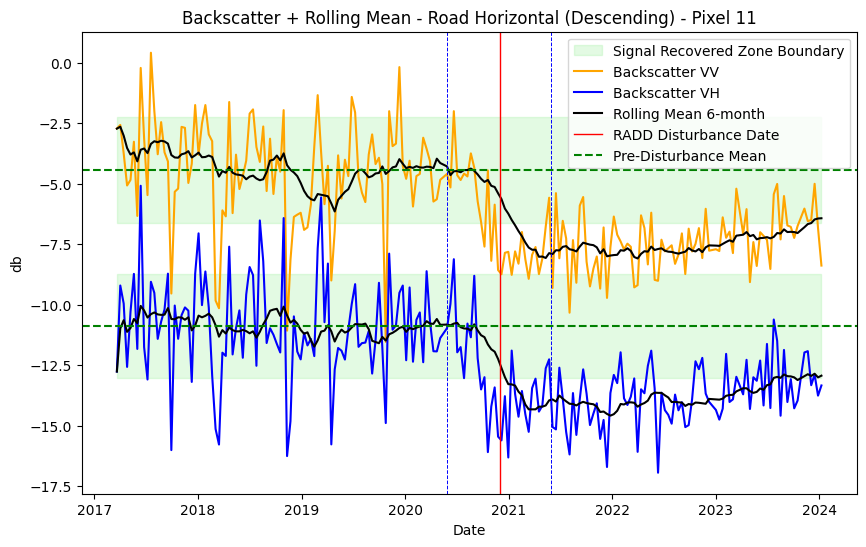

In [10]:
# Plot time series from one pixel as an example
id_pixel = 'Pixel_3000' # define the number of pixel
pixel = sorted_df.loc[sorted_df['id'] == id_pixel]
# Assuming you have defined 'pixel', 'pre_disturbance_df', and other variables

plt.figure(figsize=(10, 6))
plt.fill_between(pixel['date'], pre_disturbance_df.loc[pre_disturbance_df['id'] == id_pixel]['pre_mean_std_vh'].iloc[0], pre_disturbance_df.loc[pre_disturbance_df['id'] == id_pixel]['pre_mean_plus_std_vh'].iloc[0], color='lightgreen', alpha=0.25, label = 'Signal Recovered Zone Boundary')
plt.fill_between(pixel['date'], pre_disturbance_df.loc[pre_disturbance_df['id'] == id_pixel]['pre_mean_std_vv'].iloc[0], pre_disturbance_df.loc[pre_disturbance_df['id'] == id_pixel]['pre_mean_plus_std_vv'].iloc[0], color='lightgreen', alpha=0.25)
plt.plot(pixel['date'], pixel['VV'], label='Backscatter VV', color='orange')
plt.plot(pixel['date'], pixel['VH'], label='Backscatter VH', color='blue')
plt.plot(pixel['date'], pixel['rolling_mean_6month_vv'], label='Rolling Mean 6-month', color='black')
plt.plot(pixel['date'], pixel['rolling_mean_6month_vh'], color='black')

# Extract the disturbance_date from the first row
disturbance_date = pixel['start_date'].iloc[0]

# Add vertical lines at disturbance_date and post_disturbance
plt.axvline(x=disturbance_date, color='red', linewidth=1, label='RADD Disturbance Date')
plt.axvline(x=pixel['pre_disturbance_date'].iloc[0], color='blue', linestyle='--', linewidth=0.7)
plt.axvline(x=pixel['post_disturbance_date'].iloc[0], color='blue', linestyle='--', linewidth=0.7)

# Add horizontal lines for pre-disturbance mean
plt.axhline(y=pre_disturbance_df.loc[pre_disturbance_df['id'] == id_pixel]['pre_vh_mean'].iloc[0], color='green', linestyle='--', label='Pre-Disturbance Mean')
plt.axhline(y=pre_disturbance_df.loc[pre_disturbance_df['id'] == id_pixel]['pre_vv_mean'].iloc[0], color='green', linestyle='--')

# Label the axes and add legend
plt.xlabel('Date')
plt.ylabel('db')
plt.legend()
plt.title('Backscatter + Rolling Mean - Road Horizontal (Descending) - Pixel 11')

# Show the plot
plt.grid(False)
plt.show()

# 3. Detecting Signal Recovery

In [11]:
results = []

# Loop through each unique 'id'
for pixel_id in pixel_list:
    # Filter data for the current 'id'
    pixel_data = sorted_df[sorted_df['id'] == pixel_id]

    # Skip the iteration if pixel_data is empty
    if pixel_data.empty:
        continue
    # Calculate results for each window for the current 'id'
    post_disturbance_date = pixel_data['post_disturbance_date'].iloc[0]  # Assuming it's the same for all rows of the 'id'

    start_date = post_disturbance_date
    max_date = pixel_data['date'].max()  # Assuming 'date' is your date column
    window_size = pd.DateOffset(months=3)
    step_size = pd.DateOffset(months=1)

    while start_date <= max_date:
        end_date = start_date + window_size

        # Filter data within the current window
        window_data = pixel_data[(pixel_data['date'] >= start_date) & (pixel_data['date'] <= end_date)]

        # Calculate the mean and std within the window
        window_mean_vh = window_data['rolling_mean_6month_vh'].mean()
        window_mean_vv = window_data['rolling_mean_6month_vv'].mean()
        window_std_vh = window_data['rolling_mean_6month_vh'].std()
        window_std_vv = window_data['rolling_mean_6month_vv'].std()

        # standard deviation
        mean_std_vh = window_mean_vh - window_std_vh
        mean_plus_std_vh = window_mean_vh + window_std_vh
        mean_std_vv = window_mean_vv - window_std_vv
        mean_plus_std_vv = window_mean_vv + window_std_vv
    # Annotate the t-test result on the plot
        # Append the results for the current window and 'id' to the list
        filtered_vh = pre_disturbance_df[pre_disturbance_df['id'] == pixel_id]['pre_mean_std_vh']
        if not filtered_vh.empty:
            if mean_std_vh > filtered_vh.iloc[0]:
                result_vh = 'Recovered'
            else:
                result_vh = 'Not Recovered'
        else:
            result_vh = 'Unknown'  # Or handle it in a way that makes sense for your analysis

        filtered_vv = pre_disturbance_df[pre_disturbance_df['id'] == pixel_id]['pre_mean_std_vv']
        if not filtered_vv.empty:
            if mean_std_vv > filtered_vv.iloc[0]:
                result_vv = 'Recovered'
            else:
                result_vv = 'Not Recovered'
        else:
            result_vv = 'Unknown'

        results.append({
            'Pixel ID': pixel_id,
            'Start Date': start_date,
            'End Date': end_date,
            'Window Mean VH': window_mean_vh,
            'Window Mean VV': window_mean_vv,
            'Window Std VH': window_std_vh,
            'Window Std VV': window_std_vv,
            'Mean-Std (VV)': mean_std_vv,
            'Mean+Std (VV)': mean_plus_std_vv,
            'Mean-Std (VH)': mean_std_vh,
            'Mean+Std (VH)': mean_plus_std_vh,
            'Result (VH)': result_vh,
            'Result (VV)': result_vv,
        })

        # Update 'start_date' for the next iteration
        start_date = start_date + step_size

# Convert the results to a DataFrame
results_df = pd.DataFrame(results).dropna() if results else pd.DataFrame()


In [12]:
def update_recovery_status(data):
    modified_data = data.copy()  # Create a copy of the original DataFrame
    for pid, group in data.groupby('Pixel ID'):
        for i in range(2, len(group) - 2):
            if group.iloc[i]['Result (VH)'] == 'Not Recovered':
                before = group.iloc[i - 2:i]['Result (VH)'].eq('Recovered').all()
                after = group.iloc[i + 1:i + 3]['Result (VH)'].eq('Recovered').all()
                if before and after:
                    modified_data.at[group.index[i], 'Result (VH)'] = 'Recovered'
                # Add the same logic for 'Result (VV)'
                before_vv = group.iloc[i - 2:i]['Result (VV)'].eq('Recovered').all()
                after_vv = group.iloc[i + 1:i + 3]['Result (VV)'].eq('Recovered').all()
                if before_vv and after_vv:
                    modified_data.at[group.index[i], 'Result (VV)'] = 'Recovered'
            if group.iloc[i]['Result (VH)'] == 'Recovered':
                before = group.iloc[i - 2:i]['Result (VH)'].eq('Not Recovered').all()
                after = group.iloc[i + 1:i + 3]['Result (VH)'].eq('Not Recovered').all()
                if before and after:
                    modified_data.at[group.index[i], 'Result (VH)'] = 'Not Recovered'
                # Add the same logic for 'Result (VV)'
                before_vv = group.iloc[i - 2:i]['Result (VV)'].eq('Not Recovered').all()
                after_vv = group.iloc[i + 1:i + 3]['Result (VV)'].eq('Not Recovered').all()
                if before_vv and after_vv:
                    modified_data.at[group.index[i], 'Result (VV)'] = 'Not Recovered'
    return modified_data

# Applying the function to 'Result (VH)' and 'Result (VV)' columns
modified_df = update_recovery_status(results_df)


In [13]:
# Function to check the status based on the last 6 rows
# This approach accounts for the possibility of fluctuations in signal intensity, ensuring that the recovery classification is based on a sustained improvement
def check_last_6_vh(rows):
    last_6 = rows.tail(6)
    if last_6['Result (VH)'].eq('Recovered').rolling(5).sum().max() >= 5:
        return 'Recovered'
    else:
        return 'Not Recovered'
def check_last_6_vv(rows):
    last_6 = rows.tail(6)
    if last_6['Result (VV)'].eq('Recovered').rolling(5).sum().max() >= 5:
        return 'Recovered'
    else:
        return 'Not Recovered'
# Applying the function to the DataFrame grouped by 'Pixel ID'
last_result_df_vh = modified_df.groupby('Pixel ID').apply(check_last_6_vh).reset_index(name='Status VH')
last_result_df_vv = modified_df.groupby('Pixel ID').apply(check_last_6_vv).reset_index(name='Status VV')

# Displaying the result
last_result_df = last_result_df_vh.merge(last_result_df_vv, on = 'Pixel ID')

# 4. Temporal and Spatial Patterns of Signal Recovery

In [14]:
# Create an empty DataFrame to store results
percentage_year_df = pd.DataFrame(columns=[
    'Pixel ID',
])
# Loop through unique 'Pixel ID'
for pixel_id in pixel_list:
    # Filter DataFrame for each 'Pixel ID'
    pixel_data = results_df[results_df['Pixel ID'] == pixel_id]
    pixel_data['Start Date'] = pd.to_datetime(pixel_data['Start Date'])
    loc_date = sorted_df[sorted_df['id'] == pixel_id]
    # Calculate results for each window for the current 'id'
    if loc_date.empty:
        print(f"No post_disturbance_date found for Pixel ID {pixel_id}.")
        continue  # Skip this Pixel ID and move to the next one in the loop
    post_disturbance_date = loc_date['post_disturbance_date'].iloc[0]

    vh_filter = pre_disturbance_df['id'] == pixel_id
    vv_filter = pre_disturbance_df['id'] == pixel_id
    if vh_filter.any() and vv_filter.any():
      vh_mean_value = pre_disturbance_df.loc[vh_filter, 'pre_vh_mean'].iloc[0]
      vv_mean_value = pre_disturbance_df.loc[vv_filter, 'pre_vv_mean'].iloc[0]

      # Calculate characteristics per six months
      month2_after_df = pixel_data[pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(months=2))]
      month4_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(months=4))) & (pixel_data['Start Date'] > month2_after_df['Start Date'].max())]
      month6_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(months=6))) & (pixel_data['Start Date'] > month4_after_df['Start Date'].max())]
      month8_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(months=8))) & (pixel_data['Start Date'] > month6_after_df['Start Date'].max())]
      month10_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(months=10))) & (pixel_data['Start Date'] > month8_after_df['Start Date'].max())]
      month12_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=1))) & (pixel_data['Start Date'] > month10_after_df['Start Date'].max())]
      month14_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=1)+pd.DateOffset(months=2))) & (pixel_data['Start Date'] > month12_after_df['Start Date'].max())]
      month16_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=1)+pd.DateOffset(months=4))) & (pixel_data['Start Date'] > month14_after_df['Start Date'].max())]
      month18_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=1)+pd.DateOffset(months=6))) & (pixel_data['Start Date'] > month16_after_df['Start Date'].max())]
      month20_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=1)+pd.DateOffset(months=8))) & (pixel_data['Start Date'] > month18_after_df['Start Date'].max())]
      month22_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=1)+pd.DateOffset(months=10))) & (pixel_data['Start Date'] > month20_after_df['Start Date'].max())]
      month24_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=2))) & (pixel_data['Start Date'] > month22_after_df['Start Date'].max())]
      month26_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=2)+pd.DateOffset(months=2))) & (pixel_data['Start Date'] > month24_after_df['Start Date'].max())]
      month28_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=2)+pd.DateOffset(months=4))) & (pixel_data['Start Date'] > month26_after_df['Start Date'].max())]
      month30_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=2)+pd.DateOffset(months=6))) & (pixel_data['Start Date'] > month28_after_df['Start Date'].max())]
      month32_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=2)+pd.DateOffset(months=8))) & (pixel_data['Start Date'] > month30_after_df['Start Date'].max())]
      month34_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=2)+pd.DateOffset(months=10))) & (pixel_data['Start Date'] > month32_after_df['Start Date'].max())]
      month36_after_df = pixel_data[(pixel_data['Start Date'] <= (post_disturbance_date + pd.DateOffset(years=3))) & (pixel_data['Start Date'] > month34_after_df['Start Date'].max())]

      # Calculate percentage signal recovered VH
      percentage_signal_recovered_vh_2month = ((month2_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_4month = ((month4_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_6month = ((month6_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_8month = ((month8_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_10month = ((month10_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_12month = ((month12_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_14month = ((month14_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_16month = ((month16_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_18month = ((month18_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_20month = ((month20_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_22month = ((month22_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_24month = ((month24_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_26month = ((month26_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_28month = ((month28_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_30month = ((month30_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_32month = ((month32_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_34month = ((month34_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100
      percentage_signal_recovered_vh_36month = ((month36_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / (vh_mean_value - pixel_data['Window Mean VH'].min())) * 100

      # Calculate percentage signal recovered VV
      percentage_signal_recovered_vv_2month = ((month2_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_4month = ((month4_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_6month = ((month6_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_8month = ((month8_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_10month = ((month10_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_12month = ((month12_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_14month = ((month14_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_16month = ((month16_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_18month = ((month18_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_20month = ((month20_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_22month = ((month22_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_24month = ((month24_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_26month = ((month26_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_28month = ((month28_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_30month = ((month30_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_32month = ((month32_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_34month = ((month34_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100
      percentage_signal_recovered_vv_36month = ((month36_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / (vv_mean_value - pixel_data['Window Mean VV'].min())) * 100

      # Calculate Magnitude per 6months:
      magnitude_vh_2 = vh_mean_value - month2_after_df['Window Mean VH'].min()
      magnitude_vh_4 = vh_mean_value - month4_after_df['Window Mean VH'].min()
      magnitude_vh_6 = vh_mean_value - month6_after_df['Window Mean VH'].min()
      magnitude_vh_8 = vh_mean_value - month8_after_df['Window Mean VH'].min()
      magnitude_vh_10 = vh_mean_value - month10_after_df['Window Mean VH'].min()
      magnitude_vh_12 = vh_mean_value - month12_after_df['Window Mean VH'].min()
      magnitude_vh_14 = vh_mean_value - month14_after_df['Window Mean VH'].min()
      magnitude_vh_16 = vh_mean_value - month16_after_df['Window Mean VH'].min()
      magnitude_vh_18 = vh_mean_value- month18_after_df['Window Mean VH'].min()
      magnitude_vh_20 = vh_mean_value- month20_after_df['Window Mean VH'].min()
      magnitude_vh_22 = vh_mean_value- month22_after_df['Window Mean VH'].min()
      magnitude_vh_24 = vh_mean_value- month24_after_df['Window Mean VH'].min()
      magnitude_vh_26 = vh_mean_value - month26_after_df['Window Mean VH'].min()
      magnitude_vh_28 = vh_mean_value - month28_after_df['Window Mean VH'].min()
      magnitude_vh_30 = vh_mean_value - month30_after_df['Window Mean VH'].min()
      magnitude_vh_32 = vh_mean_value - month32_after_df['Window Mean VH'].min()
      magnitude_vh_34 = vh_mean_value - month34_after_df['Window Mean VH'].min()
      magnitude_vh_36 = vh_mean_value -month36_after_df['Window Mean VH'].min()
      magnitude_vv_2 = vv_mean_value - month2_after_df['Window Mean VV'].min()
      magnitude_vv_4 = vv_mean_value - month4_after_df['Window Mean VV'].min()
      magnitude_vv_6 = vv_mean_value - month6_after_df['Window Mean VV'].min()
      magnitude_vv_8 = vv_mean_value - month8_after_df['Window Mean VV'].min()
      magnitude_vv_10 = vv_mean_value - month10_after_df['Window Mean VV'].min()
      magnitude_vv_12 = vv_mean_value - month12_after_df['Window Mean VV'].min()
      magnitude_vv_14 = vv_mean_value - month14_after_df['Window Mean VV'].min()
      magnitude_vv_16 = vv_mean_value - month16_after_df['Window Mean VV'].min()
      magnitude_vv_18 = vv_mean_value - month18_after_df['Window Mean VV'].min()
      magnitude_vv_20 = vv_mean_value - month20_after_df['Window Mean VV'].min()
      magnitude_vv_22 = vv_mean_value - month22_after_df['Window Mean VV'].min()
      magnitude_vv_24 = vv_mean_value - month24_after_df['Window Mean VV'].min()
      magnitude_vv_26 = vv_mean_value - month26_after_df['Window Mean VV'].min()
      magnitude_vv_28 = vv_mean_value - month28_after_df['Window Mean VV'].min()
      magnitude_vv_30 = vv_mean_value - month30_after_df['Window Mean VV'].min()
      magnitude_vv_32 = vv_mean_value - month34_after_df['Window Mean VV'].min()
      magnitude_vv_34 = vv_mean_value - month34_after_df['Window Mean VV'].min()
      magnitude_vv_36 = vv_mean_value - month36_after_df['Window Mean VV'].min()

      #R80p
      calculateRRI_vh = (month30_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / ((vh_mean_value) - pixel_data['Window Mean VH'].min())
      calculateRRI_vv = (month30_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / ((vv_mean_value) - pixel_data['Window Mean VV'].min())
      calculateR80p_vh = (month30_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) / ((vh_mean_value*1.2) - pixel_data['Window Mean VH'].min())
      calculateR80p_vv = (month30_after_df['Window Mean VV'].max() - pixel_data['Window Mean VV'].min()) / ((vv_mean_value*1.2) - pixel_data['Window Mean VV'].min())
      calculateYrYr_vh = (month30_after_df['Window Mean VH'].max() - pixel_data['Window Mean VH'].min()) /3
      calculateYrYr_vv = (month30_after_df['Window Mean VV'].max()- pixel_data['Window Mean VV'].min()) / 3
      # Append results to result_df for each 'Pixel ID'
      percentage_year_df = percentage_year_df.append({
          'Pixel ID': pixel_id,
          'Percentage Signal Recovered VH 2': percentage_signal_recovered_vh_2month,
          'Percentage Signal Recovered VH 4': percentage_signal_recovered_vh_4month,
          'Percentage Signal Recovered VH 6': percentage_signal_recovered_vh_6month,
          'Percentage Signal Recovered VH 8': percentage_signal_recovered_vh_8month,
          'Percentage Signal Recovered VH 10': percentage_signal_recovered_vh_10month,
          'Percentage Signal Recovered VH 12': percentage_signal_recovered_vh_12month,
          'Percentage Signal Recovered VH 14': percentage_signal_recovered_vh_14month,
          'Percentage Signal Recovered VH 16': percentage_signal_recovered_vh_16month,
          'Percentage Signal Recovered VH 18': percentage_signal_recovered_vh_18month,
          'Percentage Signal Recovered VH 20': percentage_signal_recovered_vh_20month,
          'Percentage Signal Recovered VH 22': percentage_signal_recovered_vh_22month,
          'Percentage Signal Recovered VH 24': percentage_signal_recovered_vh_24month,
          'Percentage Signal Recovered VH 26': percentage_signal_recovered_vh_26month,
          'Percentage Signal Recovered VH 28': percentage_signal_recovered_vh_28month,
          'Percentage Signal Recovered VH 30': percentage_signal_recovered_vh_30month,
          'Percentage Signal Recovered VH 32': percentage_signal_recovered_vh_32month,
          'Percentage Signal Recovered VH 34': percentage_signal_recovered_vh_34month,
          'Percentage Signal Recovered VH 36': percentage_signal_recovered_vh_36month,
          'Percentage Signal Recovered VV 2': percentage_signal_recovered_vv_6month,
          'Percentage Signal Recovered VV 4': percentage_signal_recovered_vv_12month,
          'Percentage Signal Recovered VV 6': percentage_signal_recovered_vv_6month,
          'Percentage Signal Recovered VV 8': percentage_signal_recovered_vv_8month,
          'Percentage Signal Recovered VV 10': percentage_signal_recovered_vv_10month,
          'Percentage Signal Recovered VV 12': percentage_signal_recovered_vv_12month,
          'Percentage Signal Recovered VV 14': percentage_signal_recovered_vv_14month,
          'Percentage Signal Recovered VV 16': percentage_signal_recovered_vv_16month,
          'Percentage Signal Recovered VV 18': percentage_signal_recovered_vv_18month,
          'Percentage Signal Recovered VV 20': percentage_signal_recovered_vv_20month,
          'Percentage Signal Recovered VV 22': percentage_signal_recovered_vv_22month,
          'Percentage Signal Recovered VV 24': percentage_signal_recovered_vv_24month,
          'Percentage Signal Recovered VV 26': percentage_signal_recovered_vv_26month,
          'Percentage Signal Recovered VV 28': percentage_signal_recovered_vv_28month,
          'Percentage Signal Recovered VV 30': percentage_signal_recovered_vv_30month,
          'Percentage Signal Recovered VV 32': percentage_signal_recovered_vv_32month,
          'Percentage Signal Recovered VV 34': percentage_signal_recovered_vv_34month,
          'Percentage Signal Recovered VV 36': percentage_signal_recovered_vv_36month,
          'Magnitude VH 6': magnitude_vh_6,
          'Magnitude VH 12': magnitude_vh_12,
          'Magnitude VH 18': magnitude_vh_18,
          'Magnitude VH 24': magnitude_vh_24,
          'Magnitude VH 30': magnitude_vh_30,
          'Magnitude VH 36': magnitude_vh_36,
          'Magnitude VV 6': magnitude_vv_6,
          'Magnitude VV 12': magnitude_vv_12,
          'Magnitude VV 18': magnitude_vv_18,
          'Magnitude VV 24': magnitude_vv_24,
          'Magnitude VV 30': magnitude_vv_30,
          'Magnitude VV 36': magnitude_vv_36,
          'RRI (VH)': calculateRRI_vh,
          'RRI (VV)': calculateRRI_vv,
          'R80p (VH)': calculateR80p_vh,
          'R80p (VV)': calculateR80p_vv,
          'YrYr (VH)': calculateYrYr_vh,
          'YrYr (VV)': calculateYrYr_vv,
      }, ignore_index=True)

results_percentage_df = percentage_year_df.merge(last_result_df, on ='Pixel ID')

Streaming output truncated to the last 5000 lines.
<ipython-input-14-51226eb1e1da>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pixel_data['Start Date'] = pd.to_datetime(pixel_data['Start Date'])
<ipython-input-14-51226eb1e1da>:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  percentage_year_df = percentage_year_df.append({
<ipython-input-14-51226eb1e1da>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pixel_data

In [15]:
modified_percentage_cols = results_percentage_df[
    ['Percentage Signal Recovered VH 2',
     'Percentage Signal Recovered VH 4',
     'Percentage Signal Recovered VH 6',
     'Percentage Signal Recovered VH 8',
     'Percentage Signal Recovered VH 10',
     'Percentage Signal Recovered VH 12',
     'Percentage Signal Recovered VH 14',
     'Percentage Signal Recovered VH 16',
     'Percentage Signal Recovered VH 18',
     'Percentage Signal Recovered VH 20',
     'Percentage Signal Recovered VH 22',
     'Percentage Signal Recovered VH 24',
     'Percentage Signal Recovered VH 26',
     'Percentage Signal Recovered VH 28',
     'Percentage Signal Recovered VH 30',
     'Percentage Signal Recovered VH 32',
     'Percentage Signal Recovered VH 34',
     'Percentage Signal Recovered VH 36',
     'Percentage Signal Recovered VV 2',
     'Percentage Signal Recovered VV 4',
     'Percentage Signal Recovered VV 6',
     'Percentage Signal Recovered VV 8',
     'Percentage Signal Recovered VV 10',
     'Percentage Signal Recovered VV 12',
     'Percentage Signal Recovered VV 14',
     'Percentage Signal Recovered VV 16',
     'Percentage Signal Recovered VV 18',
     'Percentage Signal Recovered VV 20',
     'Percentage Signal Recovered VV 22',
     'Percentage Signal Recovered VV 24',
     'Percentage Signal Recovered VV 26',
     'Percentage Signal Recovered VV 28',
     'Percentage Signal Recovered VV 30',
     'Percentage Signal Recovered VV 32',
     'Percentage Signal Recovered VV 34',
     'Percentage Signal Recovered VV 36']
]

# Replacing values less than 0 with 100 and values greater than 100 with 100
modified_percentage_cols = modified_percentage_cols.apply(lambda x: np.where(x < 0, 100, np.where(x > 100, 100, x)))

# Combine modified percentages with the rest of the columns in percentage_year_df
new_percentage_df = pd.concat([results_percentage_df.drop(modified_percentage_cols.columns, axis=1), modified_percentage_cols], axis=1)

# 5. Recovery Metrics

In [16]:
merge_metrics = results_percentage_df[['Pixel ID','RRI (VH)', 'RRI (VV)', 'R80p (VH)', 'R80p (VV)', 'YrYr (VH)', 'YrYr (VV)']]

In [17]:
merge_metrics['RRI (VH) normalized'] = np.where(merge_metrics['RRI (VH)'] > 1, 1, np.where(merge_metrics['RRI (VH)'] < 0, 0, merge_metrics['RRI (VH)']))
merge_metrics['RRI (VV) normalized'] = np.where(merge_metrics['RRI (VV)'] > 1, 1, np.where(merge_metrics['RRI (VV)'] < 0, 0, merge_metrics['RRI (VV)']))


<ipython-input-17-6adedb1fd0e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_metrics['RRI (VH) normalized'] = np.where(merge_metrics['RRI (VH)'] > 1, 1, np.where(merge_metrics['RRI (VH)'] < 0, 0, merge_metrics['RRI (VH)']))
<ipython-input-17-6adedb1fd0e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_metrics['RRI (VV) normalized'] = np.where(merge_metrics['RRI (VV)'] > 1, 1, np.where(merge_metrics['RRI (VV)'] < 0, 0, merge_metrics['RRI (VV)']))


In [18]:
merge_metrics['YrYr (VH) normalized'] = (merge_metrics['YrYr (VH)'] - merge_metrics['YrYr (VH)'].min()) / (merge_metrics['YrYr (VH)'].max() - merge_metrics['YrYr (VH)'].min())
merge_metrics['YrYr (VH) normalized'] = merge_metrics['YrYr (VH) normalized'].clip(lower=0, upper=1)
merge_metrics['YrYr (VV) normalized'] = (merge_metrics['YrYr (VV)'] - merge_metrics['YrYr (VV)'].min()) / (merge_metrics['YrYr (VV)'].max() - merge_metrics['YrYr (VV)'].min())
merge_metrics['YrYr (VV) normalized'] = merge_metrics['YrYr (VV) normalized'].clip(lower=0, upper=1)


<ipython-input-18-b9d3bd593999>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_metrics['YrYr (VH) normalized'] = (merge_metrics['YrYr (VH)'] - merge_metrics['YrYr (VH)'].min()) / (merge_metrics['YrYr (VH)'].max() - merge_metrics['YrYr (VH)'].min())
<ipython-input-18-b9d3bd593999>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_metrics['YrYr (VH) normalized'] = merge_metrics['YrYr (VH) normalized'].clip(lower=0, upper=1)
<ipython-input-18-b9d3bd593999>:3: SettingWithCopyWarning: 
A value is tr

In [19]:
merge_metrics['R80p (VH) normalized'] = np.where(merge_metrics['R80p (VH)'] > 1, 1, np.where(merge_metrics['R80p (VH)'] < 0, 0, merge_metrics['R80p (VH)']))
merge_metrics['R80p (VV) normalized'] = np.where(merge_metrics['R80p (VV)'] > 1, 1, np.where(merge_metrics['R80p (VV)'] < 0, 0, merge_metrics['R80p (VV)']))


<ipython-input-19-2be455d6d3a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_metrics['R80p (VH) normalized'] = np.where(merge_metrics['R80p (VH)'] > 1, 1, np.where(merge_metrics['R80p (VH)'] < 0, 0, merge_metrics['R80p (VH)']))
<ipython-input-19-2be455d6d3a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_metrics['R80p (VV) normalized'] = np.where(merge_metrics['R80p (VV)'] > 1, 1, np.where(merge_metrics['R80p (VV)'] < 0, 0, merge_metrics['R80p (VV)']))


In [20]:
# Convert to Excel
result_file_percentage= file_path.replace('.csv', '_RESULT_PERCENTAGE.csv')
new_percentage_df.to_csv(result_file_percentage)
result_file_metrics= file_path.replace('.csv', '_RESULT_METRICS.csv')
merge_metrics.to_csv(result_file_metrics)